In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

import warnings

# 모든 FutureWarning 무시
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Processing

In [2]:
def load_data(filename):
    """
    이미지를 불러옵니다.
    Parameters:
        filename: str
            h5 파일에서 데이터를 불러옵니다.
    Returns:
        np.ndarray, pd.DataFrame, np.ndarray, 
        train 이미지, train spot 정보, test 이미지, test spot 정보
    """
    images, images_test = list(), list()
    spots, spots_test = list(), list()
    with h5py.File(filename, "r") as h5file:
        train_images = h5file["images/Train"]
        train_spots = h5file["spots/Train"]
    
        num_train_slides = len(train_images)
        # Train 이미지를 불러옵니다.
        # 하나의 텐서로 만들기 위해 이미지의 크기를 2000x2000으로 균일하게 만듭니다.
        for i, slide_name in enumerate(train_images.keys()):
            image = np.array(train_images[slide_name])
            p1 = 2000 - image.shape[0]
            p2 = 2000 - image.shape[1]
            images.append(
                np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
            )
            spots.append(pd.DataFrame(np.array(train_spots[slide_name])).assign(slide = i))
        # Test 이미지를 불러옵니다.
        test_images = h5file["images/Test"]
        test_spots = h5file["spots/Test"]
        sample = 'S_7'
        image = np.array(test_images[sample])
        p1 = 2000 - image.shape[0]
        p2 = 2000 - image.shape[1]
        images_test.append(np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge'))
        spots_test.append(pd.DataFrame(np.array(test_spots[sample])).assign(slide = 0))
    # EfficientNet의 형식으로 바꿉니다.
    with tf.device('/CPU:0'):
        images = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images))
    df_spots = pd.concat(spots).reset_index(drop = True)
    with tf.device('/CPU:0'):
        images_test = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images_test))
    df_spots_test = pd.concat(spots_test).reset_index(drop = True)
    return images, df_spots, images_test, df_spots_test

def make_img_proc_info(df, img_with, img_height):
    """
    
    """
    return df.assign(
        left = lambda x: x['x'] - img_width // 2,
        right = lambda x: x['x'] + img_width // 2,
        top = lambda x: x['y'] - img_height // 2,
        bottom = lambda x: x['y'] + img_height // 2,
        lpad = lambda x: -(x['left'].where(x['left'] < 0, 0)),
        rpad = lambda x: -(2000 - x['right']).where(x['right'] > 2000, 0),
        tpad = lambda x: -(x['top'].where(x['top'] < 0, 0)),
        bpad = lambda x: -(2000 - x['bottom']).where(x['bottom'] > 2000, 0)
    ).assign(
        left = lambda x: x['left'].clip(0, 2000),
        right = lambda x: x['right'].clip(0, 2000),
        top = lambda x: x['top'].clip(0, 2000),
        bottom = lambda x: x['bottom'].clip(0, 2000),
    )

def create_tf_ds(df):
    if (pd.Series(targets).isin(df.columns)).all():
        return tf.data.Dataset.from_tensor_slices(
            ({
                i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
            }, df[targets])
        )
    else:
        return tf.data.Dataset.from_tensor_slices({
            i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
        })

def proc_images(X, images):
    return tf.pad(
        images[X['slide'], X['left']:X['right'], X['top']:X['bottom'], :], 
        paddings = [(X['lpad'], X['rpad']), (X['tpad'], X['bpad']), (0, 0)],
        constant_values=1
    )

augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

images, df_spots, images_test, df_spots_test = load_data("data/elucidata_ai_challenge_data.h5")
targets = [i for i in df_spots.columns if i.startswith('C')]

target_proc = make_pipeline(FunctionTransformer(np.log, np.exp),  StandardScaler())
target_proc.fit(df_spots[targets])
df_spots[targets] = target_proc.transform(df_spots[targets])

In [3]:
df_spots['slide'].unique()

array([0, 1, 2, 3, 4, 5])

In [4]:
from scipy.stats import spearmanr

def create_model(img_width, img_height):
    input_shape = (img_width, img_height, 3)
    enet = tf.keras.applications.EfficientNetB0(
        include_top = False, 
        weights = 'imagenet',
        input_shape = input_shape,
        pooling = 'avg'
    )
    inputs = tf.keras.Input(shape = input_shape)
    x = enet(inputs, training = False)
    x = tf.keras.layers.Dropout(0.5)(x)
    d1 = tf.keras.layers.Dense(256, activation = 'relu', kernel_initializer = 'HeUniform')
    x = d1(x)
    d2 = tf.keras.layers.Dense(len(targets))
    outputs = d2(x)
    m = tf.keras.models.Model(inputs, outputs)
    return m, (enet, d1, d2)

def reconstruct_model(layers):
    input_shape = (img_width, img_height, 3)
    inputs = tf.keras.Input(shape = input_shape)
    x = layers[0](inputs, training = True)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = layers[1](x)
    outputs = layers[2](x)
    m = tf.keras.models.Model(inputs, outputs)
    return m

def train_model(
        m, train_idx, valid_idx, learning_rate, 
        target_proc = FunctionTransformer(lambda x: x, lambda x: x), 
        batch_size = 32, epochs = 20, step = ''
    ):

    ds_cv_train = create_tf_ds(
        df_spots.iloc[train_idx].pipe(
            lambda x: x.drop(columns = targets).join(
                x[targets].clip(lower = x[targets].quantile(0.05), upper = x[targets].quantile(0.95), axis = 1)
            )
        ).pipe(
            lambda x: pd.concat([
                x, x.sample(n = batch_size - (len(x) % batch_size))
            ])
        )
    ).shuffle(5000).map(
        lambda X, Y: (proc_images(X, images), Y)
    ).map(
        lambda X, Y: (data_augmentation(X), Y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

    ds_cv_prd = create_tf_ds(
        df_spots.iloc[train_idx]
    ).map(
        lambda X, Y: (proc_images(X, images), Y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    
    if valid_idx is not None:
        ds_valid = create_tf_ds(df_spots.iloc[valid_idx]).map(
            lambda X, Y: (proc_images(X, images), Y)
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    else:
        ds_valid = None
    """
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=5000,
        alpha=0.1
    )
    """
    lr_schedule = learning_rate
    m.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
        metrics = [tf.keras.metrics.MeanSquaredError()]
    )

    df_true_train = df_spots.iloc[train_idx][targets].pipe(
        lambda x: pd.DataFrame(
            target_proc.inverse_transform(x), index = x.index, columns = targets
        )
    )
    if valid_idx is not None:
        df_true = df_spots.iloc[valid_idx][targets].pipe(
            lambda x: pd.DataFrame(
                target_proc.inverse_transform(x), index = x.index, columns = targets
            )
        )
    else:
        df_true = None
    progress_bar = tqdm(total = epochs, desc=step)
    scores_train, scores_valid = list(), list()
    df_prd = None
    for i in range(epochs):
        hist = m.fit(ds_cv_train, epochs = 1, verbose = 0)
        df_prd = pd.DataFrame(
            target_proc.inverse_transform(m.predict(ds_cv_prd, verbose = 0)), 
            index = df_true_train.index, columns = targets
        )
        scores_train.append(
            df_true_train.apply(lambda x: spearmanr(x, df_prd.loc[x.name])[0], axis=1).mean()
        )
        metric = "train coef: {:.4f}".format(scores_train[-1])
        if valid_idx is not None:
            df_prd = pd.DataFrame(
                target_proc.inverse_transform(m.predict(ds_valid, verbose = 0)), 
                index = df_true.index, columns = targets
            )
            scores_valid.append(
                df_true.apply(lambda x: spearmanr(x, df_prd.loc[x.name])[0], axis=1).mean()
            )
            metric = metric + ", valid coef: {:.4f}".format(scores_valid[-1])
        progress_bar.set_postfix_str(metric)
        progress_bar.update(1)
    progress_bar.close()
    return (scores_train, scores_valid), df_prd

# Validation

In [5]:
img_width = 224
img_height = 224
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [ ]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 6)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    gkf.split(df_spots[['x', 'y']], df_spots[targets], groups = df_spots['slide'])
):
    m, layers = create_model(img_width, img_height)
    score_1, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-8, 
        target_proc = target_proc, batch_size = 32, epochs = 20, step = 'train {}'.format(i)
    )
    """
    m = reconstruct_model(layers)
    score_2, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 10, step = 'fine tuning {}'.format(i)
    )
    """
    scores.append(score_1)
    oofs.append(df_prd)
df_oof = pd.concat(oofs, axis = 0)

In [12]:
joblib.dump((df_oof, scores), 'result/cv_eff_b0_2.joblib')

['result/cv_eff_b0_2.joblib']

In [11]:
from sklearn.metrics import r2_score, mean_squared_error
df_oof, scores = joblib.load('result/cv_eff_b0_2.joblib')
df_oof.sort_index(inplace = True)
df_spots[targets].apply(
    lambda x: (
        r2_score(x, df_oof[x.name]), mean_squared_error(x, df_oof[x.name])
    )
).T

,0,1
C1,-0.159789,1.159789
C2,-0.006190,1.006190
C3,-0.323286,1.323286
C4,-0.096841,1.096841
C5,-0.296933,1.296933
C6,-0.001777,1.001777
C7,0.000417,0.999583
C8,-0.000017,1.000017
C9,-0.006209,1.006209
C10,-0.000926,1.000926


In [30]:
for i, (train_idx, valid_idx) in enumerate(
    gkf.split(df_spots[['x', 'y']], df_spots[targets], groups = df_spots['slide'])
):
    df_true = df_spots.iloc[valid_idx][targets].pipe(
        lambda x: pd.DataFrame(
            target_proc.inverse_transform(x), index = x.index, columns = targets
        )
    )
    break
    
df_prd[targets].apply(
    lambda x: spearmanr(df_true.loc[x.name, targets], x)[0], axis=1
).mean()

0.6239958538481472

In [7]:
img_width = 112
img_height = 112
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [8]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 6)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    gkf.split(df_spots[['x', 'y']], df_spots[targets], groups = df_spots['slide'])
):
    m, layers = create_model(img_width, img_height)
    score_1, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 20, step = 'train {}'.format(i)
    )
    """
    m = reconstruct_model(layers)
    score_2, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 10, step = 'fine tuning {}'.format(i)
    )
    """
    scores.append(score_1)
    oofs.append(df_prd)
df_oof = pd.concat(oofs, axis = 0)

train 0:   0%|          | 0/20 [00:00<?, ?it/s]

train 1:   0%|          | 0/20 [00:00<?, ?it/s]

train 2:   0%|          | 0/20 [00:00<?, ?it/s]

train 3:   0%|          | 0/20 [00:00<?, ?it/s]

train 4:   0%|          | 0/20 [00:00<?, ?it/s]

train 5:   0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
joblib.dump((df_oof, scores), 'result/cv_eff_b0_2_112.joblib')

['result/cv_eff_b0_2_112.joblib']

In [9]:
from sklearn.metrics import r2_score, mean_squared_error
df_oof, scores = joblib.load('result/cv_eff_b0_2_112.joblib')
df_oof.sort_index(inplace = True)
df_spots[targets].apply(
    lambda x: (
        r2_score(x, df_oof[x.name]), mean_squared_error(x, df_oof[x.name])
    )
).T.sort_values(0)

,0,1
C5,-0.369790,1.369790
C16,-0.208683,1.208683
C3,-0.140943,1.140943
C1,-0.127710,1.127710
C4,-0.103117,1.103117
C24,-0.021387,1.021387
C17,-0.021225,1.021225
C31,-0.012082,1.012082
C6,-0.011539,1.011539
C15,-0.009967,1.009967


In [18]:
img_width = 56
img_height = 56
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [19]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 6)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    gkf.split(df_spots[['x', 'y']], df_spots[targets], groups = df_spots['slide'])
):
    m, layers = create_model(img_width, img_height)
    score_1, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 20, step = 'train {}'.format(i)
    )
    """
    m = reconstruct_model(layers)
    score_2, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 10, step = 'fine tuning {}'.format(i)
    )
    """
    scores.append(score_1)
    oofs.append(df_prd)
df_oof = pd.concat(oofs, axis = 0)

train 0:   0%|          | 0/20 [00:00<?, ?it/s]

train 1:   0%|          | 0/20 [00:00<?, ?it/s]

train 2:   0%|          | 0/20 [00:00<?, ?it/s]

train 3:   0%|          | 0/20 [00:00<?, ?it/s]

train 4:   0%|          | 0/20 [00:00<?, ?it/s]

train 5:   0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
joblib.dump((df_oof, scores), 'result/cv_eff_b0_2_56.joblib')

['result/cv_eff_b0_2_56.joblib']

In [29]:
from sklearn.metrics import r2_score, mean_squared_error
df_oof, scores = joblib.load('result/cv_eff_b0_2_56.joblib')
df_oof.sort_index(inplace = True)
df_spots[targets].apply(
    lambda x: (
        r2_score(x, df_oof[x.name]), mean_squared_error(x, df_oof[x.name])
    )
).T

,0,1
C1,-0.147890,1.147890
C2,-0.006984,1.006984
C3,-0.095260,1.095260
C4,-1.010399,2.010399
C5,-2344.210007,2345.210007
C6,-0.145934,1.145934
C7,-0.010191,1.010191
C8,-0.000446,1.000446
C9,-0.100409,1.100409
C10,-0.409092,1.409092


In [30]:
df_oof.loc[
    df_oof['C5'] == df_oof['C5'].max()
]

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
7245,0.580168,0.077169,0.070218,0.004269,4409.643555,0.00091,0.156937,0.004262,0.000181,0.01298,...,0.000224,0.010019,0.050761,0.000134,0.000449,0.04586,0.009805,0.000351,0.074735,0.083272


In [44]:
df_spots.loc[
    df_oof['C5'] == df_oof['C5'].max()
]

,x,y,C1,C2,C3,C4,C5,C6,C7,C8,...,C35,slide,left,right,top,bottom,lpad,rpad,tpad,bpad
7245,1113,1305,-1.272881,-0.139007,-1.18213,-1.954583,-2.066833,-2.414367,-0.651837,0.351682,...,-0.918027,4,1001,1225,1193,1417,0,0,0,0


In [45]:
df_spots['C5'].describe()

count    8.349000e+03
mean    -1.634019e-16
std      1.000060e+00
min     -3.193702e+00
25%     -6.999692e-01
50%      3.600749e-01
75%      7.461398e-01
max      1.486787e+00
Name: C5, dtype: float64

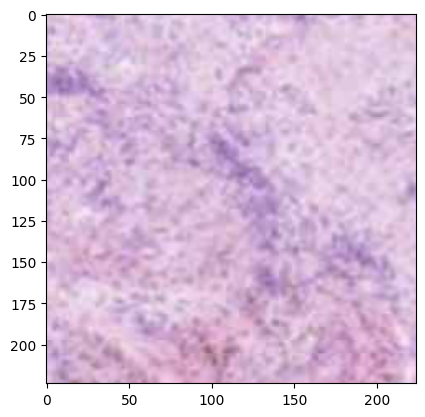

In [43]:
plt.imshow(
    proc_images(df_spots.loc[7245, ].astype('int'), images)
)

# Train

In [6]:
img_width = 224
img_height = 224
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [8]:
m, layers = create_model(img_width, img_height)
score_1, df_prd = train_model(
    m, df_spots.index, None, learning_rate = 1e-6, 
    target_proc = target_proc, batch_size = 32, epochs = 20, step = 'train'
)

train:   0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'scores' is not defined

In [7]:
"""
inputs = tf.keras.Input(shape = input_shape)
x = enet(inputs, training = True)
x = tf.keras.layers.Dropout(0.2)(x)
x = d1(x)
outputs = d2(x)
m = tf.keras.models.Model(inputs, outputs)
m.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),  # Low learning rate
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)
hist = m.fit(ds_train, epochs=10)
"""
''

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - loss: 0.8789 - mean_squared_error: 0.8789
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - loss: 0.8748 - mean_squared_error: 0.8748
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - loss: 0.8705 - mean_squared_error: 0.8705
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.8666 - mean_squared_error: 0.8666
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - loss: 0.8645 - mean_squared_error: 0.8645
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - loss: 0.8619 - mean_squared_error: 0.8619
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.8578 - mean_squared_error: 0.8578
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.8542 - mean_squared_error: 0.8542
Epoch 9/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - loss: 0.8518 - mean_squared_error: 0.8518
Epoch 10/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - loss: 0.8491 - mean_squared_error: 0.8491


In [9]:
joblib.dump(m.get_weights(), 'model/eff_b0_2.joblib')

['model/eff_b0_2.joblib']

In [10]:
joblib.dump(target_proc, 'model/target_proc_2.joblib') 

['model/target_proc_2.joblib']

In [10]:
ds_test = create_tf_ds(df_spots_test)

df_submission = pd.DataFrame(
    target_proc.inverse_transform(
        m.predict(
            ds_test.map(lambda X: proc_images(X, images_test)).batch(32)
        )
    ), columns = targets
).reset_index().rename(columns = {'index': 'ID'})

66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step


In [11]:
df_submission

,ID,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,0,0.139854,0.064018,0.076188,0.044425,0.087721,0.005078,0.012797,0.000573,0.003890,...,0.001139,0.001088,0.000957,0.002257,0.000115,0.052555,0.024842,0.000521,0.004712,0.020507
1,1,0.051364,0.077110,0.129357,0.021935,0.007879,0.002041,0.007267,0.001011,0.001386,...,0.004315,0.000774,0.000674,0.000858,0.000226,0.041766,0.025205,0.001300,0.005841,0.038908
2,2,0.052973,0.074979,0.084442,0.027101,0.060929,0.010806,0.011961,0.001323,0.002091,...,0.002159,0.000674,0.000901,0.001306,0.000196,0.048293,0.026916,0.001000,0.002311,0.028778
3,3,0.084694,0.088639,0.127371,0.023594,0.041324,0.003887,0.011799,0.000987,0.012646,...,0.007179,0.000669,0.000652,0.003581,0.000086,0.032791,0.031920,0.000718,0.003610,0.030696
4,4,0.235286,0.093400,0.089184,0.010078,0.019840,0.000833,0.004649,0.001079,0.000704,...,0.000595,0.000231,0.001385,0.000641,0.000959,0.032764,0.038569,0.002261,0.003929,0.028193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,2083,0.077080,0.094566,0.290037,0.054553,0.165372,0.002030,0.021844,0.000932,0.001730,...,0.001904,0.005125,0.000803,0.002163,0.000060,0.055566,0.075000,0.001859,0.001565,0.037228
2084,2084,0.156940,0.089073,0.160257,0.069841,0.197851,0.004648,0.016571,0.000416,0.003962,...,0.001765,0.004047,0.001326,0.003371,0.000028,0.052311,0.045426,0.001010,0.003696,0.018575
2085,2085,0.234652,0.053667,0.182117,0.091130,0.040251,0.002700,0.020946,0.001584,0.003226,...,0.003690,0.001561,0.000360,0.002399,0.000065,0.056341,0.042913,0.000556,0.005951,0.027432
2086,2086,0.095310,0.047352,0.179007,0.018158,0.042264,0.005965,0.013608,0.000725,0.003086,...,0.001524,0.001644,0.000918,0.003246,0.000061,0.049831,0.041827,0.001535,0.002553,0.026203
